In [ ]:
from keras import losses
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.models import Model
from keras.models import load_model
from keras import callbacks
from keras import optimizers
from keras.datasets import mnist
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import numpy as np

#reference https://ithelp.ithome.com.tw/articles/10207148

from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load the dataset and adjust its DPI

lfw_people_low_dpi = fetch_lfw_people(min_faces_per_person = 70, resize = 0.26).images
#lfw_people_low_dpi = lfw_people_low_dpi[:, :-3, :]
lfw_people_low_dpi = lfw_people_low_dpi.repeat(4, axis = 1).repeat(4, axis = 2)
print(" low_dpi shape =", lfw_people_low_dpi.shape)

#use first 1000 as train set, the rest 288 as test set
x_train_low_dpi = lfw_people_low_dpi[:1000]
x_test_low_dpi = lfw_people_low_dpi[1000:]

# ==============================================================================

lfw_people_high_dpi = fetch_lfw_people(min_faces_per_person = 70, resize = 1.03).images
#lfw_people_high_dpi = lfw_people_high_dpi[:, :-7, :-1]
print("high_dpi shape =", lfw_people_high_dpi.shape)

x_train_high_dpi = lfw_people_high_dpi[:1000]
x_test_high_dpi = lfw_people_high_dpi[1000:]

 low_dpi shape = (1288, 128, 96)
high_dpi shape = (1288, 128, 96)


In [ ]:
# normalize
x_train_low_dpi = x_train_low_dpi.astype('float32') / 255.0
x_test_low_dpi = x_test_low_dpi.astype('float32') / 255.0


x_train_high_dpi = x_train_high_dpi.astype('float32') / 255.0
x_test_high_dpi = x_test_high_dpi.astype('float32') / 255.0

# ======================================================

x_train_low_dpi = np.reshape(x_train_low_dpi, (len(x_train_low_dpi), 128, 96, 1))
print("x_train_low_dpi shape =", x_train_low_dpi.shape)
x_test_low_dpi = np.reshape(x_test_low_dpi, (len(x_test_low_dpi), 128, 96, 1))
print("x_test_low_dpi shape =", x_test_low_dpi.shape)


x_train_high_dpi = np.reshape(x_train_high_dpi, (len(x_train_high_dpi), 128, 96, 1))
print("x_train_high_dpi shape =", x_train_high_dpi.shape)
x_test_high_dpi = np.reshape(x_test_high_dpi, (len(x_test_high_dpi), 128, 96, 1))
print("x_test_high_dpi shape =", x_test_high_dpi.shape)

x_train_low_dpi shape = (1000, 128, 96, 1)
x_test_low_dpi shape = (288, 128, 96, 1)
x_train_high_dpi shape = (1000, 128, 96, 1)
x_test_high_dpi shape = (288, 128, 96, 1)


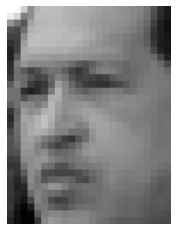

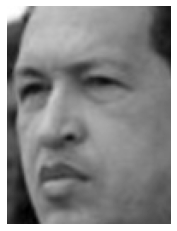

In [ ]:
def show_image(a):
  a = a.T[0]
  a = a.T
  plt.axis("off")
  plt.imshow(a, cmap = "gray")
  plt.show()

show_image(x_train_low_dpi[0])
show_image(x_train_high_dpi[0])

In [ ]:
#setup model
input = Input(shape=(128, 96, 1))
    
# Encoder
x = Conv2D(64, (3, 3), activation = "tanh", padding = "same")(input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation = "tanh", padding = "same")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation = "tanh", padding = "same")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(512, (3, 3), activation = "tanh", padding = "same")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(512, (3, 3), activation = "tanh", padding = "same")(x)

# Decoder
x = Conv2DTranspose(512, (3, 3), strides = 2, activation = "tanh", padding = "same")(x)
x = Conv2DTranspose(256, (3, 3), strides = 2, activation = "tanh", padding = "same")(x)
x = Conv2DTranspose(128, (3, 3), strides = 2, activation = "tanh", padding = "same")(x)
x = Conv2DTranspose(64, (3, 3), strides = 2, activation = "tanh", padding = "same")(x)
x = Conv2D(1, (3, 3), activation = "sigmoid", padding = "same")(x)

# Autoencoder
autoencoder = Model(input, x)

autoencoder.compile(optimizer = 'adam', loss = losses.mean_squared_error)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 96, 1)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 96, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 48, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 24, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 24, 256)       2951

In [ ]:
# set early stop
CB = callbacks.ModelCheckpoint("/content/reretry_autoencoder.model", monitor = "loss", save_best_only = True)

# train
autoencoder.fit(x_train_low_dpi, x_train_high_dpi,
                epochs = 30,
                batch_size = 64,
                shuffle = True,
                callbacks = CB,
                validation_data = (x_test_low_dpi, x_test_high_dpi)
               )

#autoencoder.save("/content/drive/MyDrive/autoencoder.model")

Epoch 1/10
16/16 [==============================] - 11s 718ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 2/10
16/16 [==============================] - 11s 701ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 3/10
16/16 [==============================] - 8s 500ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 4/10
16/16 [==============================] - 8s 499ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 5/10
16/16 [==============================] - 8s 498ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 6/10
16/16 [==============================] - 8s 499ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/10
16/16 [==============================] - 8s 530ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/10
16/16 [==============================] - 11s 719ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 9/10
16/16 [==============================] - 11s 703ms/step - loss: 9.6447e-04 - val_loss: 0.0012
Epoch 10/10
16/16 [==============================] - 11s 705ms/step - loss: 9.5319e-04 - val

In [ ]:
# load the best model

autoencoder = load_model("/content/reretry_autoencoder.model")

## Upload model to drive

#!cp autoencoder.model /content/drive/MyDrive

(128, 96, 1)
(128, 96, 1)


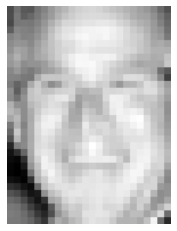

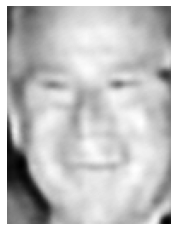

(128, 96, 1)
(128, 96, 1)


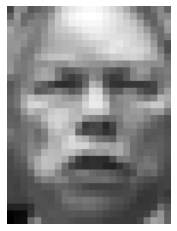

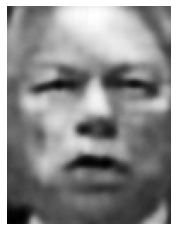

(128, 96, 1)
(128, 96, 1)


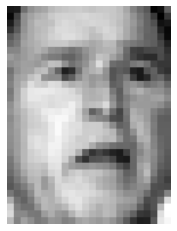

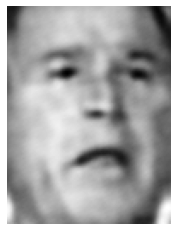

(128, 96, 1)
(128, 96, 1)


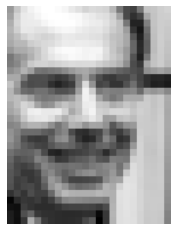

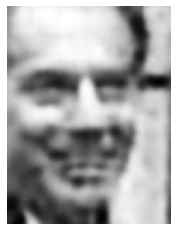

(128, 96, 1)
(128, 96, 1)


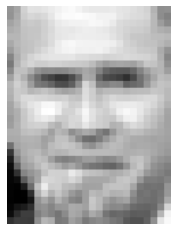

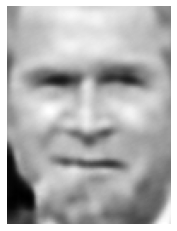

(128, 96, 1)
(128, 96, 1)


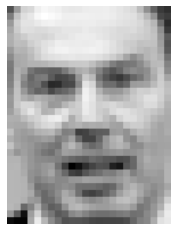

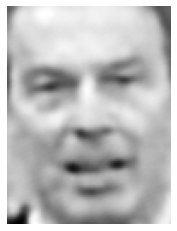

(128, 96, 1)
(128, 96, 1)


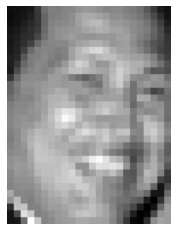

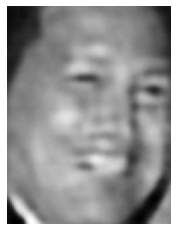

(128, 96, 1)
(128, 96, 1)


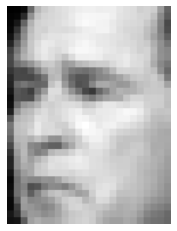

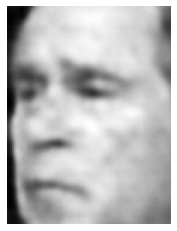

(128, 96, 1)
(128, 96, 1)


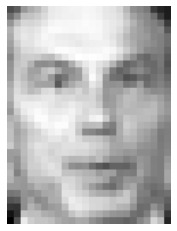

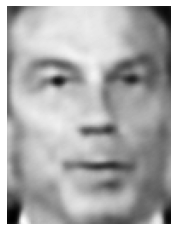

(128, 96, 1)
(128, 96, 1)


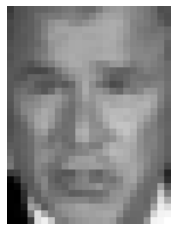

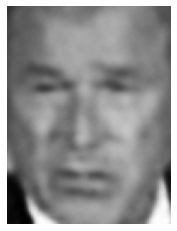

In [ ]:
#show the image
for idx in range(10):
  a = x_test_low_dpi[idx:idx + 1]
  result = autoencoder.predict(a)

  print(a[0].shape)
  print(result[0].shape)

  show_image(a[0])
  show_image(result[0])

(128, 96, 1)
(128, 96, 1)


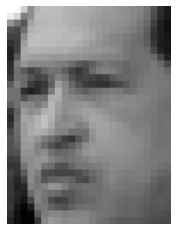

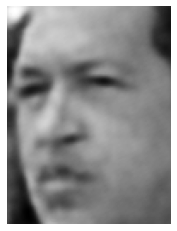

(128, 96, 1)
(128, 96, 1)


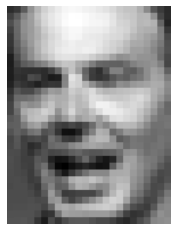

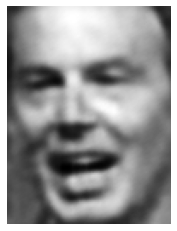

(128, 96, 1)
(128, 96, 1)


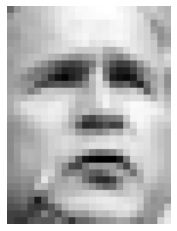

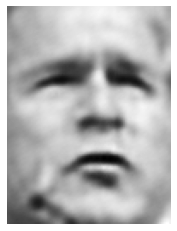

(128, 96, 1)
(128, 96, 1)


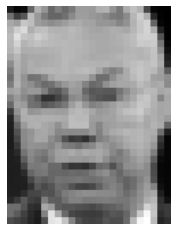

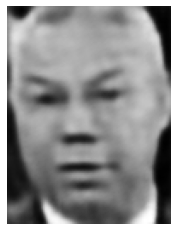

(128, 96, 1)
(128, 96, 1)


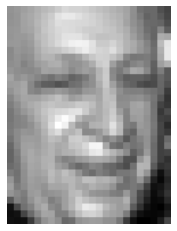

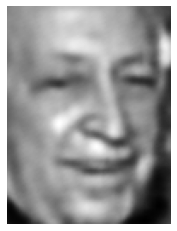

(128, 96, 1)
(128, 96, 1)


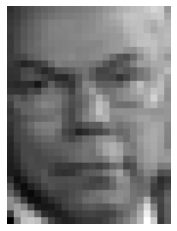

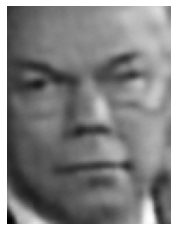

(128, 96, 1)
(128, 96, 1)


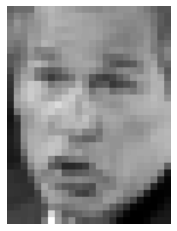

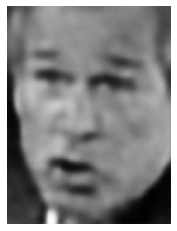

(128, 96, 1)
(128, 96, 1)


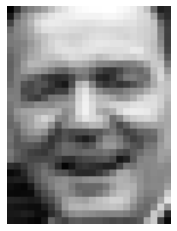

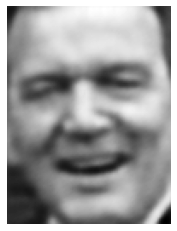

(128, 96, 1)
(128, 96, 1)


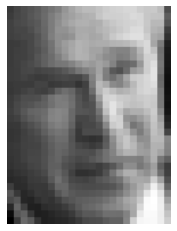

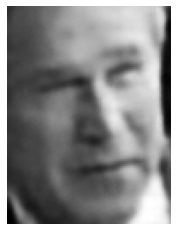

(128, 96, 1)
(128, 96, 1)


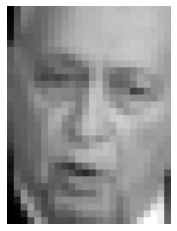

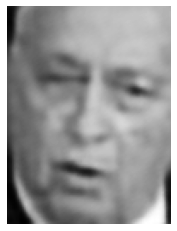

In [ ]:
#show the image
for idx in range(10):
  a = x_train_low_dpi[idx:idx + 1]
  result = autoencoder.predict(a)

  print(a[0].shape)
  print(result[0].shape)

  show_image(a[0])
  show_image(result[0])

In [ ]:
# test my own image
import PIL
import matplotlib.pyplot as plt
img = PIL.Image.open("/content/drive/MyDrive/picture_dataset/dick.jpg")
gray_img = img.convert("L")
gray_img = np.asarray(gray_img)
gray_img = np.array([gray_img.repeat(4, axis = 0).repeat(4, axis = 1)])

gray_img = np.reshape(gray_img, (len(gray_img), 128, 96, 1))

gray_img = gray_img.astype('float32') / 255.0
gray_img.shape

(1, 128, 96, 1)

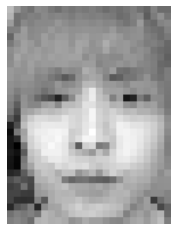

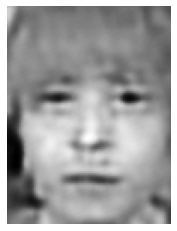

In [ ]:
show_image(gray_img[0])

result = autoencoder.predict(gray_img)
show_image(result[0])